In [1]:
!wget -P /content/gdrive/My\ Drive https://www.dropbox.com/s/r7mgjn83y9ygpzq/mnist_corrupted.npz

--2021-05-15 11:07:00--  https://www.dropbox.com/s/r7mgjn83y9ygpzq/mnist_corrupted.npz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r7mgjn83y9ygpzq/mnist_corrupted.npz [following]
--2021-05-15 11:07:00--  https://www.dropbox.com/s/raw/r7mgjn83y9ygpzq/mnist_corrupted.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdfc7bb89e569965a599e7e508a.dl.dropboxusercontent.com/cd/0/inline/BOieNcXd9hLfYXFPVN73W9myQ_NytPd4hw3isOdg8CzgtfX4aMYPeBjwB4CMD8TNhgtVeFA_NWGANn2Q29EPM_jKiKGamfC7uMArpDwfaXzec3GD_-Bk2bN2xPrdGa1pAVTSnZjVCX3kdBp4FhJss9L8/file# [following]
--2021-05-15 11:07:00--  https://ucdfc7bb89e569965a599e7e508a.dl.dropboxusercontent.com/cd/0/inline/BOieNcXd9hLfYXFPVN73W9myQ_NytPd4hw3isOdg8CzgtfX4aMYPeBjwB4CMD8TNhgtVe

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image

from typing import Tuple, List, Type, Dict, Any

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Свёрточный автокодировщик (convolutional autoencoder, CAE)

In [4]:
class DS(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]

        if self.transform:
            x = Image.fromarray(x.astype(np.uint8))
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.data)

### Напишем пайплайн для предобработки и аугментации данных

In [5]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #Эти числа - среднее и стандартное отклонение набора данных MNIST .
    torchvision.transforms.Normalize((0.1307, ), (0.3081, )),
    torchvision.transforms.RandomResizedCrop(size=(28, 28),
                                             scale=(.5, 1.0),
                                             ratio=(.8, 1.25)),
    torchvision.transforms.RandomRotation(degrees=30)
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307, ), (0.3081, ))
])

In [6]:
mnist = np.load('/content/gdrive/My Drive/mnist_corrupted.npz')
mnist_train_samples = mnist['x_train']
mnist_test_samples = mnist['x_test']
train_dataset = DS(mnist_train_samples, train_transforms)
val_dataset = DS(mnist_test_samples, val_transforms)

### Отобразим несколько произвольных примеров обучающей выборки.

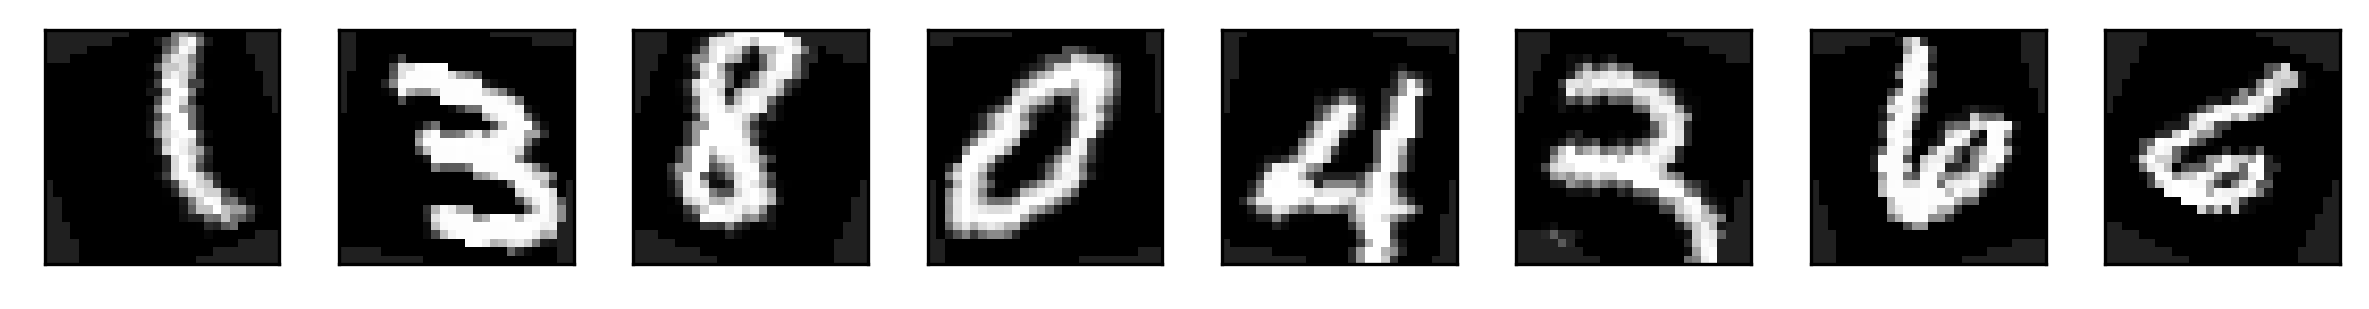

In [7]:
indices = np.random.randint(0, len(train_dataset), size=8)

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(8, 2), dpi=300)
for i, ax in enumerate(axes):
    sample_index = indices[i]
    sample = train_dataset[sample_index]
    ax.imshow(np.squeeze(sample.cpu().numpy()), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')

### Опишем класс нейросети-автокодировщика, описываемой в этом задании.

In [26]:
class ConvAutoencoder(nn.Module):
    def __init__(self, hidden_dim = 16):
        super(ConvAutoencoder, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1, stride=2)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1, stride=2)

        self.l1 = nn.Linear(196, hidden_dim)

        self.l2 = nn.Linear(hidden_dim, 196)

        
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 3, padding=1, stride=1)

        self.t_conv2 = nn.ConvTranspose2d(16, 1, 3, padding=1, stride=1)
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x_shape = x.shape


        x = x.view((-1, np.product(x.shape[1:])))
        x = F.relu(self.l1(x))

        x = F.relu(self.l2(x))
        x = x.view([-1] + list(x_shape[1:]))
        x = F.upsample(x, scale_factor=(2, 2), mode='bilinear')
        x = F.relu(self.t_conv1(x))
        x = F.upsample(x, scale_factor=(2, 2), mode='bilinear')
        x = F.sigmoid(self.t_conv2(x))
        return x

In [27]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (l1): Linear(in_features=196, out_features=16, bias=True)
  (l2): Linear(in_features=16, out_features=196, bias=True)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [28]:
model = model.to(device)

### Отобразим один произвольный пример обучающей выборки и результат вычисления нейросети на этом примере.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


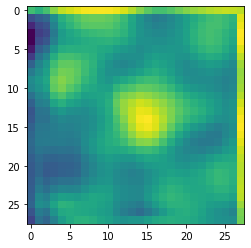

In [19]:
index = int(np.random.randint(0, len(train_dataset), size=1))
sample = train_dataset[index][0]
sample_np = np.squeeze(sample.detach().cpu().numpy())
sample_ae = model(sample.view(1, 1, 28, 28).to(device))
sample_ae_np = np.squeeze(sample_ae.detach().cpu().numpy())
plt.imshow(sample_ae_np)

### Теперь, когда мы реализовали модель и подготовили данные, можно приступить к непосредственному обучению модели.

In [20]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                initial_lr = 0.01,
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim.Adam,
                optimizer_params: Dict = {},
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ExponentialLR,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 100,
                early_stopping_patience = 10,
):
    optimizer = optimizer_class(model.parameters(), **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, gamma=0.01, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    
    for epoch in range(max_epochs):
        print(f'Epoch {epoch+1} of {max_epochs}')
        train_single_epoch(model, optimizer, loss_function, train_loader)
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
#             torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

### Реализуем функцию, производящую обучение сети на протяжении одной эпохи (полного прохода по всей обучающей выборке). На вход будет приходить модель, оптимизатор, функция потерь и объект типа DataLoader.

In [21]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    
    model.train()
    loss_fn = loss_function()

    for image in data_loader:
        optimizer.zero_grad()
        image = image.to(device)
        image_ = model(image)
        loss = loss_fn(image_, image)
        loss.backward()
        optimizer.step()

### Реализуем функцию производящую расчёт функции потерь на тестовой выборке. На вход будет приходить модель, функция потерь и DataLoader. 

In [22]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    model.eval()
    test_loss = 0.0
    loss_fn = loss_function()

    for image in data_loader:
        image = image.to(device)
        with torch.no_grad():
            image_ = model(image)
        test_loss += loss_fn(image_, image).item()
    
    return {
        'loss': test_loss / len(data_loader.dataset)
    }

У нас нет поворотов, поэтому нам нужно просто восстановить вход попиксельно. Мы хотим, чтобы у нас получилось идентичное преобразование. Идентичное преобразование тем ближе, чем ближе MSE. Поэтому в качестве функции потерь подойдет MSE. 

In [29]:
train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=nn.MSELoss, 
            max_epochs = 20,
            initial_lr=0.0001)

Epoch 1 of 20


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Validation metrics: 
{'loss': 0.010019921863079071}
Best model yet, saving
Epoch 2 of 20


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation metrics: 
{'loss': 0.009713391786813736}
Best model yet, saving
Epoch 3 of 20
Validation metrics: 
{'loss': 0.009549631649255753}
Best model yet, saving
Epoch 4 of 20
Validation metrics: 
{'loss': 0.009450370889902115}
Best model yet, saving
Epoch 5 of 20
Validation metrics: 
{'loss': 0.009449287116527557}
Best model yet, saving
Epoch 6 of 20
Validation metrics: 
{'loss': 0.00932703250348568}
Best model yet, saving
Epoch 7 of 20
Validation metrics: 
{'loss': 0.009288324147462845}
Best model yet, saving
Epoch 8 of 20
Validation metrics: 
{'loss': 0.009267886513471603}
Best model yet, saving
Epoch 9 of 20
Validation metrics: 
{'loss': 0.009279592287540436}
Epoch 10 of 20
Validation metrics: 
{'loss': 0.009228239819407463}
Best model yet, saving
Epoch 11 of 20
Validation metrics: 
{'loss': 0.00918772310912609}
Best model yet, saving
Epoch 12 of 20
Validation metrics: 
{'loss': 0.009165969780087472}
Best model yet, saving
Epoch 13 of 20
Validation metrics: 
{'loss': 0.0091053217

# Проверка результатов.

### Посмотрим, как ваш обученный автокодировщик преобразует входные примеры. В ячейке ниже приведен код для отображения произвольной пары пример-реконструкция.

In [54]:
index = int(np.random.randint(0, len(train_dataset), size=1))
sample = train_dataset[index][0]
sample_np = np.squeeze(sample.detach().cpu().numpy())
sample_ae = model(sample.view(1, 1, 28, 28).to(device))
sample_ae_np = np.squeeze(sample_ae.detach().cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


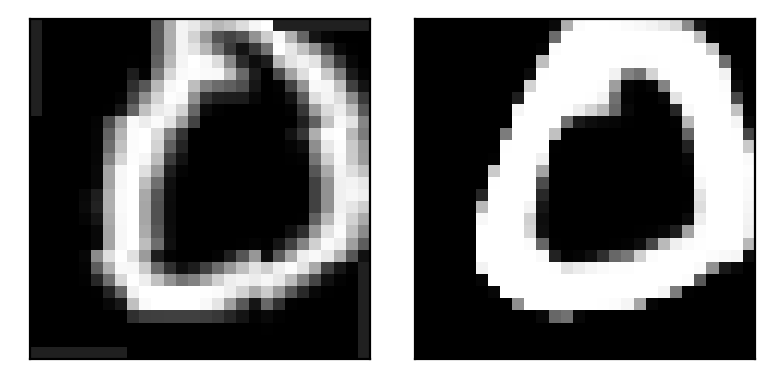

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(4, 2), dpi=200)
for i, ax in enumerate(axes):
    img = sample_np if i==0 else sample_ae_np
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')
plt.imshow(img, cmap='gray')

## Анализ значений функции потерь

### Применим обученную модель автокодировщика к данным тестовой выборки. Вычислим функцию потерь на каждом объекте тестовой выборки.

In [50]:
model.eval()
test_dataset = DS(mnist_test_samples, val_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
loss_fn = nn.MSELoss()

losses = []

with torch.no_grad():
    with tqdm(total=len(test_loader)) as pbar:
        for image in test_loader:
            curr_loss = 0.0
            image = image.to(device)
            with torch.no_grad():
                image_ = model(image)
            curr_loss = loss_fn(image_, image).item()
            losses.append(curr_loss)
            pbar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 10000/10000 [00:10<00:00, 949.27it/s]


Построим гистограмму значений функции потерь. Как мы видим наименьшее число элементов у нас с лоссом ~1.2.

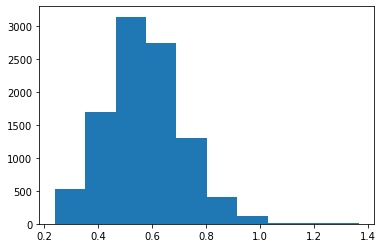

In [51]:
plt.hist(losses)
plt.show()

Эмпирическим путем (крутя loss туда-сюда и выводя картинки) я выяснил, что грань между аномалиями и корректными значениями с большим лоссом 1.139 именно при данном обучении (seed не зафиксирован):

In [52]:
losses_ = [losses.index(i) for i in losses if i > 1.18]

In [53]:
len(losses_)

16

### Отобразим сначала объекты-аномалии, а затем, в соотвествующем порядке, их реконструкции

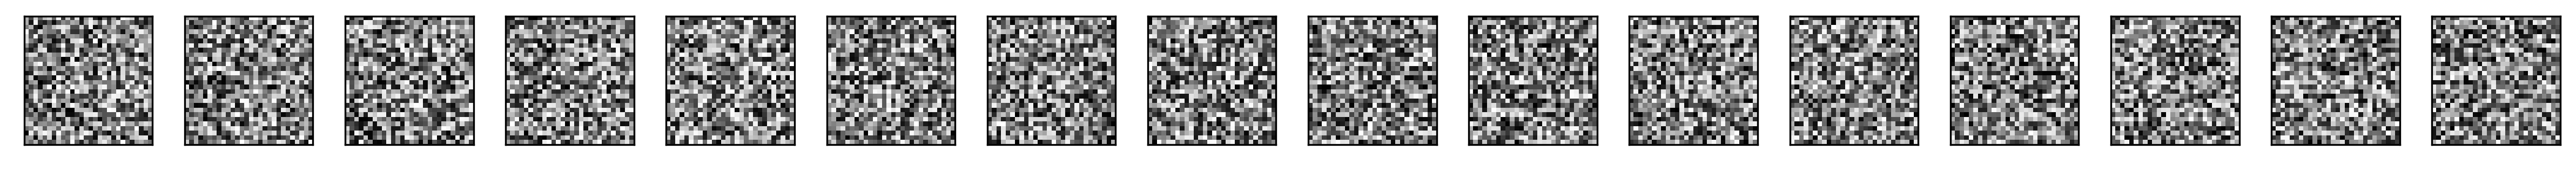

In [56]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=len(losses_), 
                         figsize=(len(losses_), 2), 
                         dpi=300)

for i, ax in enumerate(axes):
    sample_index = losses_[i]
    sample = test_dataset[sample_index]
    ax.imshow(np.squeeze(sample.cpu().numpy()), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')

Вычислите на них обученный вами автокодировщик. Отобразите рядом объекты-аномалии и их реконструкцию, вычисленную вашим автокодировщиком.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3328: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


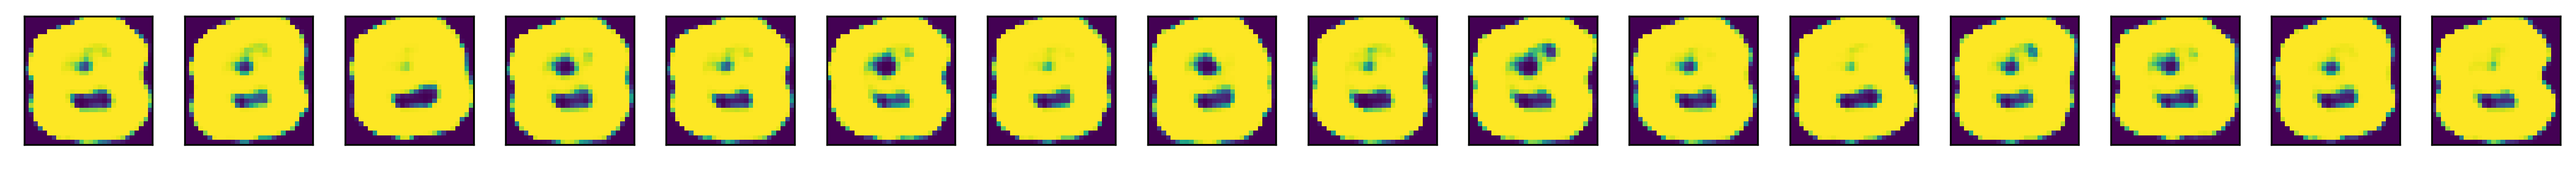

In [57]:
fig, axes = plt.subplots(nrows=1, 
                         ncols=len(losses_), 
                         figsize=(len(losses_), 2), 
                         dpi=300)

for i, ax in enumerate(axes):
    sample_index = losses_[i]
    sample = test_dataset[sample_index]
    sample_np = np.squeeze(sample.detach().cpu().numpy())
    sample_ae = model(sample.view(1, 1, 28, 28).to(device))
    sample_ae_np = np.squeeze(sample_ae.detach().cpu().numpy())
    ax.imshow(sample_ae_np)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
fig.patch.set_facecolor('white')

# Создадим файл маркировки аномалий

In [100]:
output = [0] * len(test_dataset)
for index in losses_:
    output[index] = 1

In [119]:
f = open('/content/output.txt', 'w')
output = ''.join(map(str, output))
output
f.write(output)

10000